# Import packages

In [1]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), "../../../.."))

import random
import numpy as np

import torch
from torch import distributions
from torch import nn
from torch.utils import data

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import scipy.optimize as sci_op

%reload_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

import project
import project.networks.net as net
from project.models.triple_well   import TripleWell

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
np.random.seed(seed=0)
torch.manual_seed(0)
random.seed(0)

# Visualize triple well potential
Energy landscape for triple well E is the potential used for the hyperparameter optimization. The function is an adjusted version of the triple well potential as described in ref[1], which was originally described in ref[2]. Due to a faulty implementation of the function (E1 was the original function used and E2 is the function as decribed in ref[1]) the potential had a large valley in the area to the left of the y axis and underneath the x-axis. We noticed this after initial training (before the hyperparameter optimization) and therefore deepened the potential by multiplying the whole function by a factor 3, raising the entire function by adding a scalar of 5 to the resulting function and subsequently adding a harmonic potential with a standard deviation of 0.1 such that the deep unwanted well was formed into a peak.


# refs:

1.
@article{hoffmann2021deeptime,
  title={Deeptime: a Python library for machine learning dynamical models from time series data},
  author={Hoffmann, Moritz and Scherer, Martin Konrad and Hempel, Tim and Mardt, Andreas and de Silva, Brian and Husic, Brooke Elena and Klus, Stefan and Wu, Hao and Kutz, J Nathan and Brunton, Steven and Noé, Frank},
  journal={Machine Learning: Science and Technology},
  year={2021},
  publisher={IOP Publishing}
}


2.
Christof Schütte and Marco Sarich. Metastability and Markov State Models in Molecular Dynamics. Volume 24. American Mathematical Soc., 2013.

# Extra

Handy for more artificial energy landscapes:

http://www.sfu.ca/~ssurjano/optimization.html

https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=787014841

In [3]:
def E(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

In [4]:
def E1(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)

In [5]:
def E2(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * np.exp( - x**2 - (y - (1/3))**2) - \
                3 * np.exp( - x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*(x**4) + 0.2*(y - (1/3))**4

# Finding minima

Starting from 0,0 we deploy the basin hopping algorithm to find the local minima of the function. Initially only one minimum is found, but increasing the stepsize to 2 locates all the three expected minima. The minimization algorithm finds another local minimum too however. As it turns out, the altered triple well function created for this project has a shallow high energy well in the position where the large valley used to be. This is visualized in the graphs under the minimization.

In [39]:
def func_to_min(v): # define function using 1 term containing both variables
    
    x,y=v
    
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

def callback(x,f,a): #This function should be called after EVERY local minimum obtained so also after the first local minimum. (This is the minimum obtained at step 0).
    print('CALLBACK', x,f,a)

minima_E=sci_op.basinhopping(func_to_min,[0,0],niter=100,callback=callback)

CALLBACK [-1.14368987 -0.0610423 ] -8.429077669271944 True
CALLBACK [-1.14368987 -0.06104228] -8.42907766927196 True
CALLBACK [-1.14368982 -0.06104227] -8.429077669271956 True
CALLBACK [-1.14368986 -0.06104225] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104228] -8.429077669271964 True
CALLBACK [-1.14368993 -0.06104233] -8.429077669271791 True
CALLBACK [-1.14368977 -0.06104222] -8.429077669271841 True
CALLBACK [-1.14369008 -0.06104238] -8.429077669270898 True
CALLBACK [-1.14368997 -0.06104228] -8.429077669271722 True
CALLBACK [-1.14368985 -0.06104227] -8.429077669271969 True
CALLBACK [-1.14368985 -0.06104224] -8.429077669271964 True
CALLBACK [-1.14368958 -0.06104216] -8.429077669270596 True
CALLBACK [-1.14368987 -0.06104226] -8.429077669271964 True
CALLBACK [-1.14368986 -0.06104227] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104227] -8.429077669271972 True
CALLBACK [-1.14368986 -0.06104225] -8.42907766927197 True
CALLBACK [-1.14368987 -0.06104226] -8.429077669271969 True
C

In [40]:
def func_to_min(v): # default parameter values given in pg. 4 of the SI 
    
    x,y=v
    
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

def callback(x,f,a): #This function should be called after EVERY local minimum obtained so also after the first local minimum. (This is the minimum obtained at step 0).
    print('CALLBACK', x,f,a)

minima_E=sci_op.basinhopping(func_to_min,[0,0],niter=100,stepsize=2,callback=callback)

CALLBACK [-1.14368987 -0.0610423 ] -8.429077669271944 True
CALLBACK [ 1.10631069 -0.06445889] -7.079108480168479 False
CALLBACK [-1.14368989 -0.06104213] -8.429077669271749 True
CALLBACK [-2.99934607 -2.9989863 ] 3.192558553600521 False
CALLBACK [-1.14368986 -0.06104227] -8.429077669271969 True
CALLBACK [-0.04214825  1.70835582] -1.9249774396889014 False
CALLBACK [-1.14368986 -0.06104227] -8.429077669271969 True
CALLBACK [-1.14368974 -0.0610425 ] -8.429077669271077 True
CALLBACK [-1.14368972 -0.06104222] -8.429077669271653 True
CALLBACK [ 1.10631052 -0.06445895] -7.079108480168002 False
CALLBACK [-1.14368986 -0.06104226] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104227] -8.429077669271969 True
CALLBACK [-1.14368985 -0.06104227] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104226] -8.429077669271972 True
CALLBACK [ 1.10631067 -0.06445883] -7.079108480168405 False
CALLBACK [-0.04214824  1.7083558 ] -1.9249774396889203 False
CALLBACK [-1.14369009 -0.06104208] -8.4290776692707

In [9]:
print(minima_E)

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -8.429077669271974
                          x: [-1.144e+00 -6.104e-02]
                        nit: 100
      minimization_failures: 0
                       nfev: 6407
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 0
                                 fun: -8.429077669271974
                                   x: [-1.144e+00 -6.104e-02]
                                 nit: 3
                               direc: [[ 0.000e+00  1.000e+00]
                                       [-1.484e-04  1.103e-05]]
                                nfev: 70


In [18]:
x_illustrate = np.linspace(-2.5,2.5,100)
y_illustrate = np.linspace(-2,3,100)
xx, yy = np.meshgrid(x_illustrate, y_illustrate, sparse=True)
E_illustrate = E(xx,yy)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

In [41]:
x_illustrate_1 = np.linspace(-6,2.5,100)
y_illustrate_1 = np.linspace(-6,3,100)
xx_1, yy_1 = np.meshgrid(x_illustrate_1, y_illustrate_1, sparse=True)
E_illustrate_1 = E(xx_1,yy_1)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate_1,
        x=x_illustrate_1, 
        y=y_illustrate_1,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

In [43]:
x_illustrate_1 = np.linspace(-6,2.5,100)
y_illustrate_1 = np.linspace(-6,3,100)
xx_1, yy_1 = np.meshgrid(x_illustrate_1, y_illustrate_1, sparse=True)
E_illustrate_1 = E(xx_1,yy_1)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate_1,
        x=x_illustrate_1, 
        y=y_illustrate_1,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=2,
            end=4,
            size=0.02,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

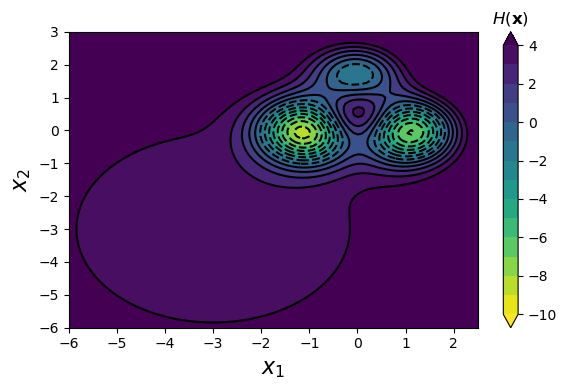

In [22]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(-10, 5, 1),extend='both',colors='k');
plt.contourf(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(-10, 5, 1),extend='both',cmap='viridis_r');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

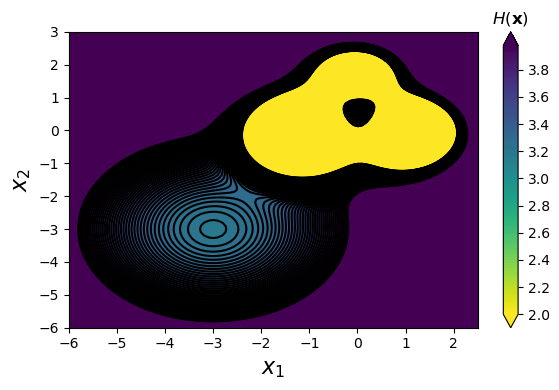

In [23]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(2, 4, 0.02),extend='both',colors='k');
plt.contourf(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(2, 4, 0.02),extend='both',cmap='viridis_r');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

# Generate sample configurations
Let's now generate sample configurations we will use as our input data set. These are meant to represent for example the results of molecular dynamics simulations. 

In [26]:
x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], 500).T
x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], 500).T

fig = go.Figure()

fig.add_trace(
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=x_state_a,
        y=y_state_a,
        mode="markers",
        name='',
        marker_color="royalblue"
    ))

fig.add_trace(
    go.Scatter(
        x=x_state_b,
        y=y_state_b,
        mode="markers",
        name='',
        marker_color="white"
    ))

# fig.update_xaxes(range=[-3,3])
# fig.update_yaxes(range=[-7,7])

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
#fig.write_image("images/double_well_with_points.pdf")

In [28]:
# x_state_a, y_state_a = np.random.multivariate_normal([-1.8,0], [[0.05, 0],[0,1]], 900).T
# x_state_b, y_state_b = np.random.multivariate_normal([1.8,0], [[0.05, 0],[0,1]], 100).T

x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], 600).T
x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], 400).T

fig = go.Figure()

fig.add_trace(
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=x_state_a,
        y=y_state_a,
        mode="markers",
        name='',
        marker_color="royalblue"
    ))

fig.add_trace(
    go.Scatter(
        x=x_state_b,
        y=y_state_b,
        mode="markers",
        name='',
        marker_color="white"
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=600,
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()

## Hyperparameter optimization

The effect of changing the hyperparameters will be checked here. The hyperparameters defined are:

-The ratio between the energy and entropy contribution in the kl loss. (not implemented just yet)

-Deepness of the network (layers in s and t networks as well as amount of masks)

-"Width" of the network (amount of nodes per hidden layer, which are only incorporated in the s and t networks)

-Sample size -- amount of samples used to perform the training by example as well as the amount of samples used to perform the training by energy.

-iterations (number of steps in the training process)


In [ ]:
# Initial parameters used for the data generation

width_network=[100,256,512,1024]
sample_size=[[1000,1000],[1000,5000],[1000,10000],[5000,5000],[10000,10000]]
iterations=[[100,100],[100,125],[100,150],[100,175],[100,200],[100,300],[125,100],[150,100],[175,100],[200,100],[300,100]]
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005]]
ratios_kl_loss=[[1,1],[1,2],[1,3],[1,4],[1,5],[5,1],[4,1],[3,1],[2,1]]

# Optimization was stopped prematurely due to time constraints.

In [ ]:
# function defining the variable in a more compact way and making altering these values optional by naturally setting them to a default value

def define_variables(hid_lay=256, l_hid=3, iter_ex=100, iter_en=100, sample_size_ex=1000, sample_size_en=1000, lr_ex=0.001, lr_en=0.0005):
    
    nodes_per_hidden_layer=hid_lay
    number_of_hidden_layers=l_hid
    iterations_train_example=iter_ex
    iterations_train_energy=iter_en
    samples_for_training_example=sample_size_ex
    samples_for_training_energy=sample_size_en
    learning_rate_for_training_example=lr_ex
    learning_rate_for_training_energy=lr_en

    return nodes_per_hidden_layer, number_of_hidden_layers, iterations_train_example, iterations_train_energy, samples_for_training_example, samples_for_training_energy \
                ,learning_rate_for_training_example, learning_rate_for_training_energy

In [44]:
# training Boltzmann Generator for the combination of all hyperparameters
# Due to some technical issues the ratio KL loss was initially not tested
# This is a slightly adjusted version of the training potential used in double_well.py in the notebooks folder of the
# original repository of the CS230 code.


triplewell = TripleWell()
temperature = 1.0

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                # define the variables to be used
                n_hidden, l_hidden, iter1, iter2, sample_size1, sample_size2, lr1, lr2 = define_variables(hid_lay=width, iter_ex=iter[0], iter_en=iter[1], sample_size_ex=size[0], sample_size_en=size[1], lr_ex=lr[0], lr_en=lr[1])

                # Initiate the network strucutre
                
                # define the RealNVP model
                nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
                nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2)) # net t
                masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
                prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
                model = net.RealNVP(nets, nett, masks, prior, triplewell, (2,))

                # initiate the the points to train by example
                # make sure initially a little more samples are drawn from the deeper well
                x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], int(0.6*sample_size1)).T 
                x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], int(0.4*sample_size1)).T 

                # combine the coordinates of both states in one array
                coords_state_a = np.stack((x_state_a,y_state_a),axis=1)
                coords_state_b = np.stack((x_state_b,y_state_b),axis=1)
                training_set = np.concatenate((coords_state_a,coords_state_b))

                # choose optimizer, set training set data to proper format and load data in batches of 1000 using the dataloader
                optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr1) 
                training_set = training_set.astype('float32')
                trainloader = data.DataLoader(dataset=training_set, batch_size=1000)

                t = 0 # iteration count

                while t < iter1:
                    for batch in trainloader:  

                        # Custom ML loss function
                        loss = model.loss_ml(batch) 

                        # Training
                        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
                        loss.backward(retain_graph=True) 
                        optimizer.step()

                        t = t + 1 # iteration count


                z, x = model.sample(sample_size2) # sample from the model after training by example, z is the latent space, x is the data space

                optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr2) 
                training_set_2 = (z.astype('float32')) # use the latent space coordinates as training set for the the training by energy
                trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=1000)

                t = iter1

                while t < iter1 + iter2:
                    for batch_z in trainloader_2:  
                        # KL loss function
                        loss = model.loss_kl(batch_z)

                        # Training on KL loss
                        # This will transfer the latent space coordinates into the data space
                        # subsequently the loss is calculated in the data space
                        # and the gradients are backpropagated to the latent space
                        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
                        loss.backward(retain_graph=True)
                        optimizer.step()

                        t = t + 1 # iteration count

                z1, x1 = model.sample(500000) # sample from the the model after training by energy, to be compared to the training by energy 

                print(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv"+"is trained")

                # save all the files to the folder 

                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",coords_state_a,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",coords_state_b,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",z,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",x,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",z1,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",x1,delimiter=",")

                print(f"and the data written to the files"+"\n")

KeyboardInterrupt: 

In [ ]:
# The training procedure took a very long time, so the simulation was stopped when most of the width=100 networks were trained.
# For efficiency the explored hyperparameters were adjusted to the following:

learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005]]
ratios_kl_loss=[[1,1],[1,2],[1,3],[1,4],[1,5],[5,1],[4,1],[3,1],[2,1]]
width_network=[256,512,1024]
sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100]]

# Using this more compact selection, running over the trainingprocedures using the different combination of hyperparameters took a reasonable famount of time

In [ ]:
# initial analysis of the results showed possible overfitting in the training by energy.
# To investigate the extend of this, the most relevant regions of the hyperparameter space were rerun using less iterations for the training by energy

learning_rates=[[0.001,0.001],[0.001,0.0005],[0.001,0.0001],[0.01,0.0005]]
width_network=[128,256,512]
sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,25],[100,50],[100,75],[200,50]]